In [3]:
pip install xgboost

  Using cached xgboost-2.0.2-py3-none-manylinux2014_x86_64.whl (297.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.layers import Input, Dense, Masking, SimpleRNN, GlobalAveragePooling1D, Dropout
from keras.layers import concatenate
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Input, Reshape, LSTM, Flatten, concatenate
from keras.models import Model
from keras.optimizers import Adam
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier

2023-11-23 11:29:19.336101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


J'ai décidé de fusionner les deux bases de données du match_1 et du match_2 pour former une seule base de données, vue qu'elles contiennent les mêmes données.

In [2]:
df_1 = pd.read_json("match_1.json")
df_2 = pd.read_json("match_2.json")
df = pd.concat([df_1, df_2], ignore_index=True)
df

label                                               norm
0     walk  [23.177037336396975, 23.361525285249378, 21.53...
1     walk  [20.998214383911275, 19.182798059840767, 18.27...
2     walk  [21.95259682019565, 20.62720484424047, 22.5554...
3     walk  [19.39209748358647, 19.30460665293087, 18.9787...
4     rest  [22.069263037713093, 19.672270483203395, 19.88...
...    ...                                                ...
1182  walk  [23.337305769963503, 20.210987911153104, 25.06...
1183  walk  [22.470322813933603, 22.552427730975246, 23.84...
1184  walk  [43.833612705797144, 46.18045998580312, 37.492...
1185  walk  [30.927599255773355, 31.26358258808756, 28.286...
1186  walk  [30.94168559492879, 47.060036178960765, 37.195...

[1187 rows x 2 columns]

**valeurs manquantes:**

In [3]:
df.isnull().sum()

label    0
norm     0
dtype: int64

Comme indiqué dans l'annonce du test, la variable "norm" contient des séquences de longueurs variables :

In [4]:
df['norm'].apply(lambda x: len(x)).unique()

array([ 72,  54,  68,  75, 181,  56,  58,  24,  16,  22,  34,  28,  30,
        42,  38,  14,  50,  44,  20,  40,  32,  48,  46,  36,  18,  67,
        23,  64,  60,  52,  70,  62,  26,  61,  90,  39,  43,  66,  49,
        74,  12,   4,  63, 142,  29,   1,  53,  21,  19,  78,  69,  98,
         7,  86,  59, 150,  88,  76,  35,  94, 134,  73, 204, 106, 140,
        80,  13,   8, 116,   3, 227, 210,  79,  92,  31,  96,  27, 179,
        82,  84, 100,  85,  25, 102, 300,   6, 118,  33,  11,  37,  81,
       110, 723,  71, 107, 136,  10, 192,  55, 156, 104, 129])

In [5]:
df["label"].value_counts()

label
run          552
walk         435
dribble       78
rest          35
pass          32
tackle        31
shot          18
cross          4
no action      2
Name: count, dtype: int64

On remarque que les actions les plus fréquentes dans la base de données sont "run" et "walk". D'autre part, les actions "cross" et "no actions" sont rares. On peut visualiser ces résultats:

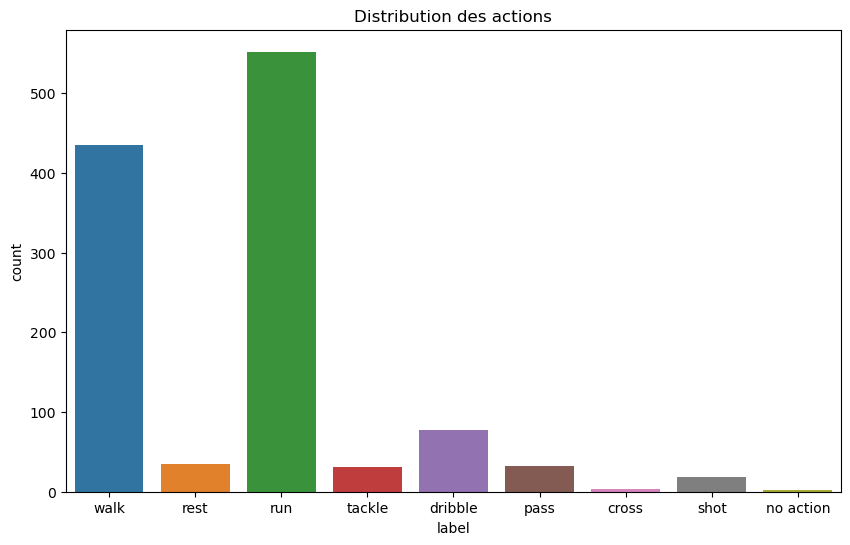

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution des actions')
plt.show()

Dans ce qui suit, je calcule la norme moyenne dans chaque séquence, puis la norme moyenne par action. On remarque que la vitesse moyenne de l'action "cross" est presque la même que celle de l'action "dribble". L'action "shot" a la vitesse moyenne la plus élevée, et l'action "rest" la plus faible.

In [7]:
df['norm_mean'] = df['norm'].apply(lambda x: sum(x) / len(x))
result = df.groupby("label")['norm_mean'].mean().reset_index()
result

label   norm_mean
0      cross   58.504386
1    dribble   58.735374
2  no action   38.652225
3       pass   66.350038
4       rest   22.084636
5        run   55.535871
6       shot  103.402763
7     tackle   69.317282
8       walk   28.869918

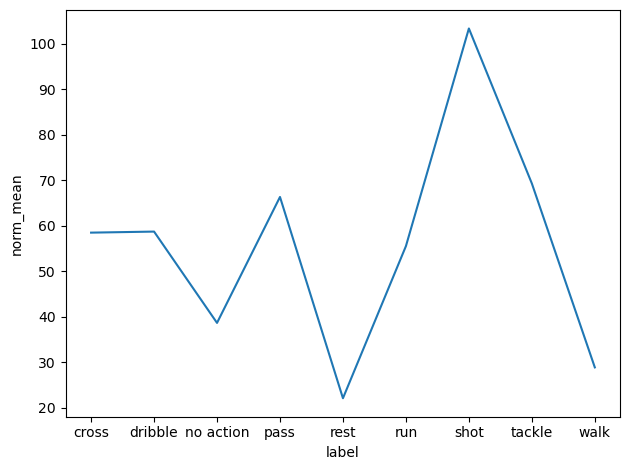

In [8]:
sns.lineplot(x='label', y='norm_mean', data=result)
plt.tight_layout()
plt.show()

Dans la suite, je trace les valeurs de la norme moyenne pour chaque action. Cela nous permet de visualiser la variabilité de la vitesse moyenne d'une observation à l'autre pour une même action.

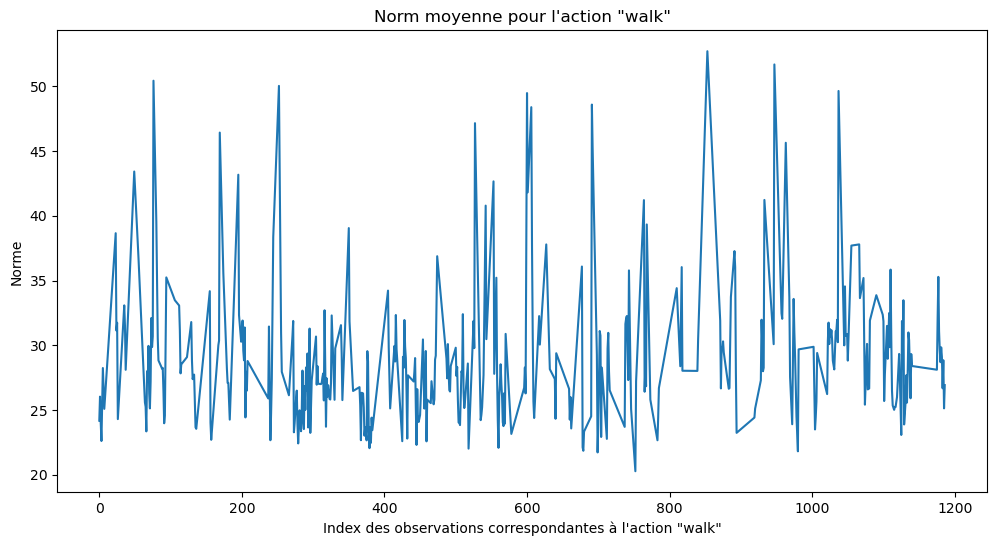

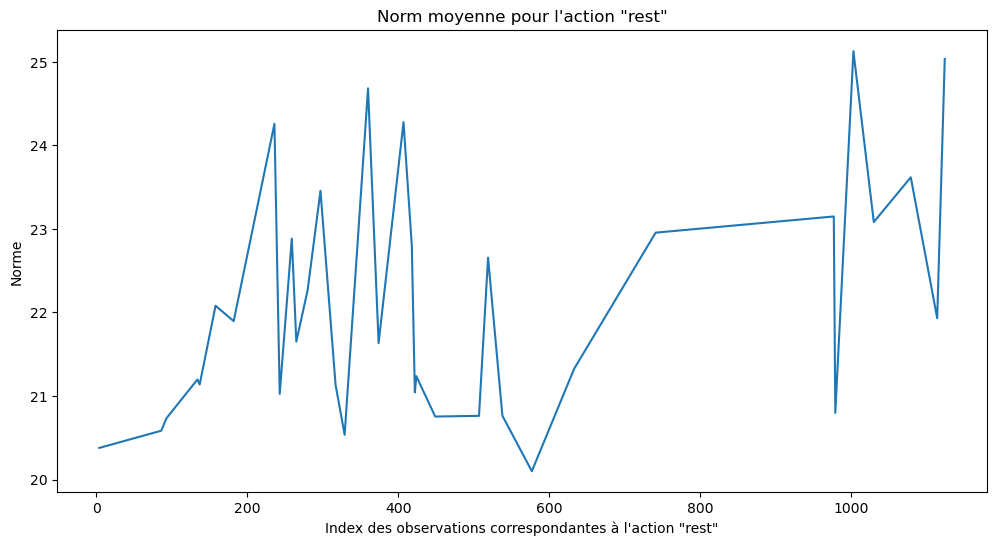

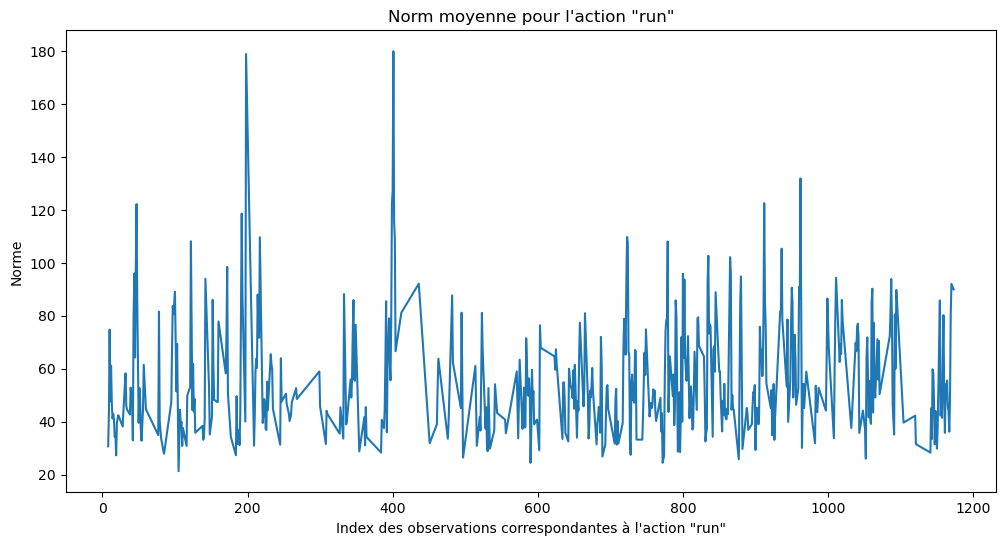

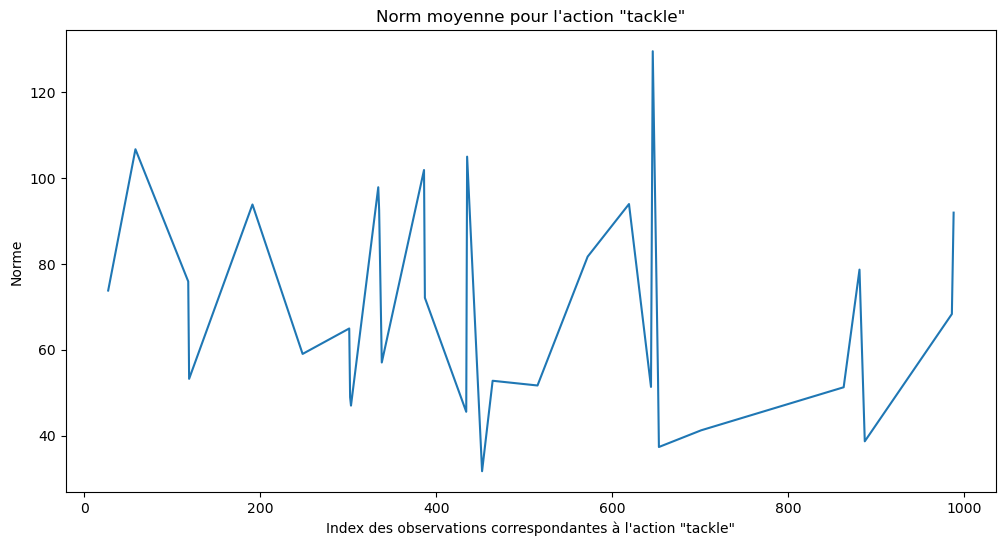

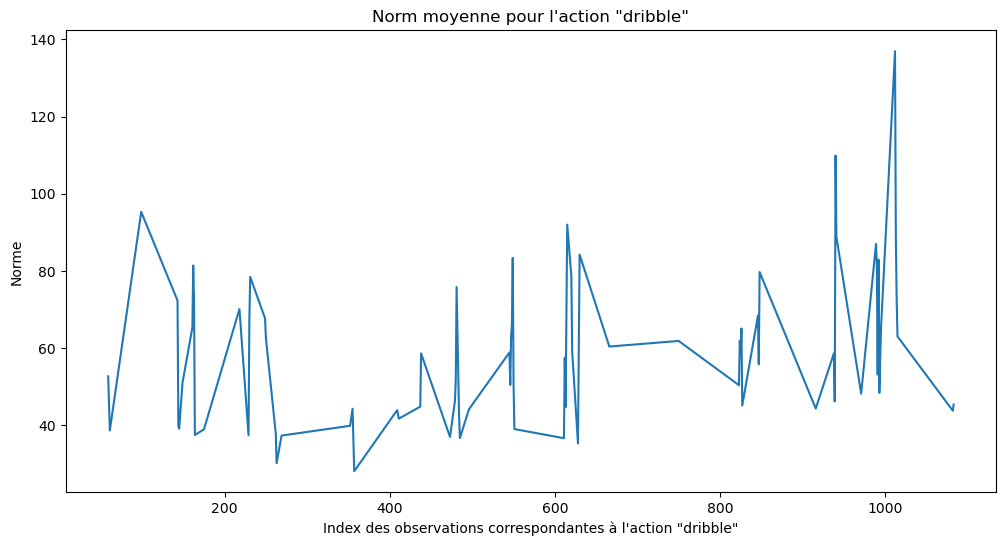

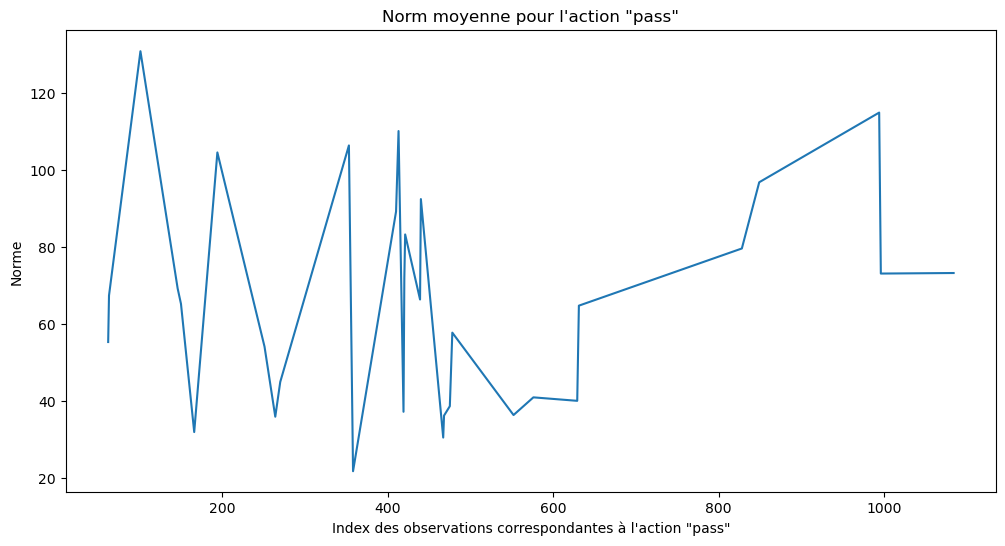

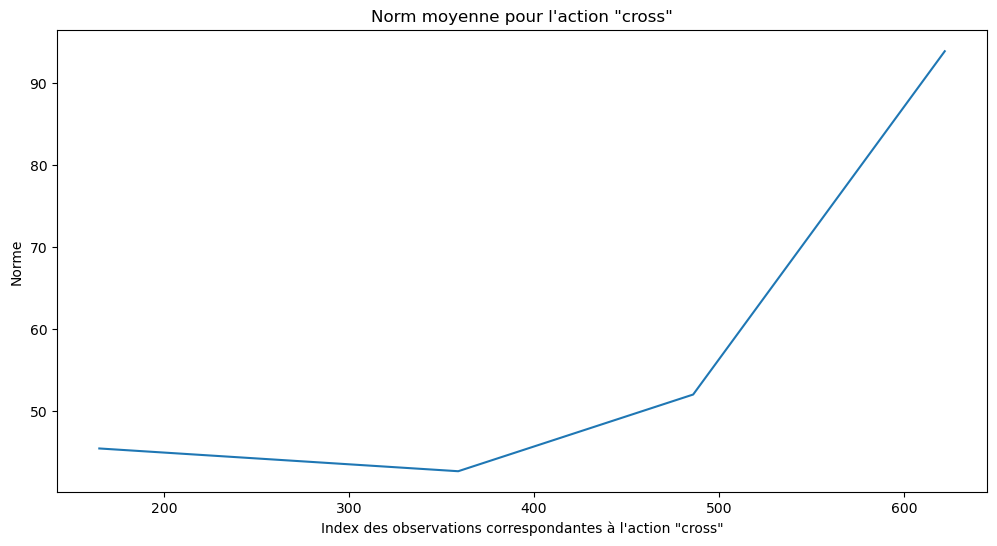

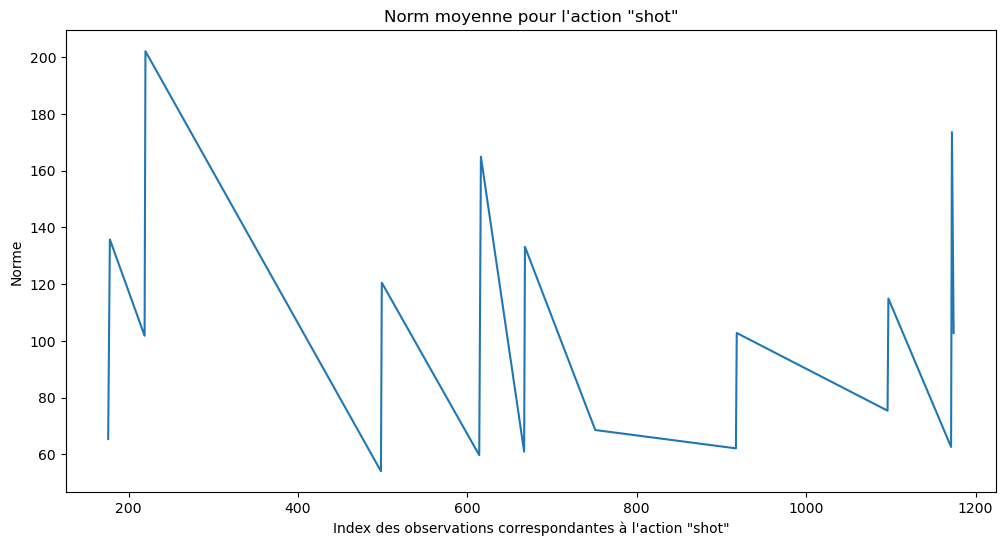

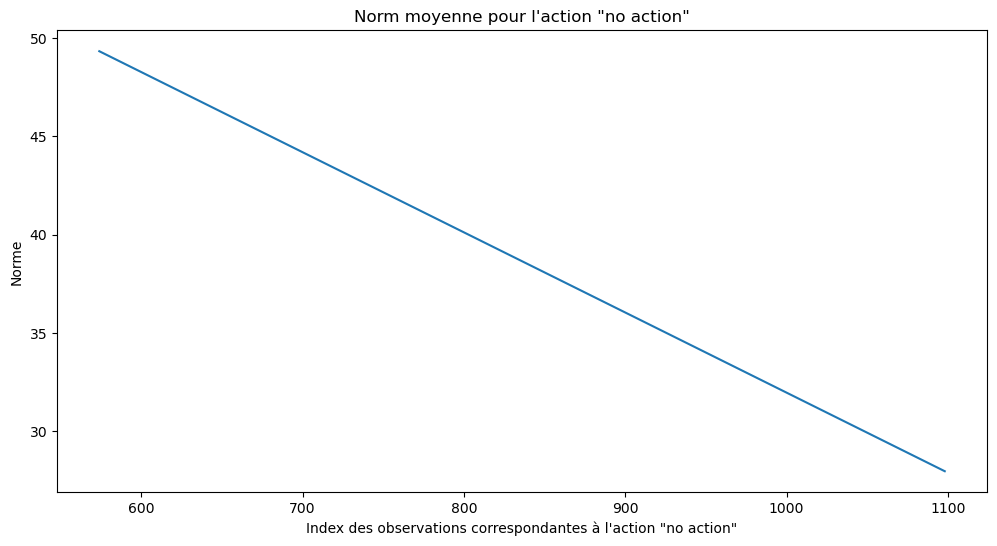

In [9]:
for variable in df["label"].unique():
    subset = df[df['label'] == variable]
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=subset.index, y='norm_mean', data=subset)
    plt.title(f'Norm moyenne pour l\'action "{variable}"')
    plt.xlabel(f'Index des observations correspondantes à l\'action "{variable}"')
    plt.ylabel('Norme')
    plt.show()

On peut aussi calculer la variance de la norme pour chaque action.

In [10]:
variance_by_action = df.groupby('label')['norm_mean'].var()
print(variance_by_action)

label
cross         571.962502
dribble       396.284477
no action     227.940205
pass          813.379493
rest            2.049456
run           452.778032
shot         1987.428480
tackle        615.257607
walk           26.934460
Name: norm_mean, dtype: float64


Dans la suite, je calcule la longueur de chaque séquence dans la variable "norm", puis je calcule la longueur moyenne par action. On remarque que les actions 'no action' et 'rest' ont les séquences les plus longues, alors que les autres actions impliquant un mouvement ont des longueurs similaires.

In [11]:
df['longueur_norm'] = df['norm'].apply(len)
result = df.groupby("label")['longueur_norm'].mean().reset_index()
result

label  longueur_norm
0      cross      52.500000
1    dribble      39.256410
2  no action     134.000000
3       pass      42.687500
4       rest     115.771429
5        run      37.657609
6       shot      33.777778
7     tackle      46.225806
8       walk      55.326437

In [12]:
result["longueur_norm"].mean()

61.91144094827676

**Recréation du jeu**

**Generative Adversial Network**

Le GAN (Generative Adversial Network) est un modèle de machine learning qui vise à générer de nouvelles données qui ressemblent aux données initiales. Un GAN est composé de deux réseaux principaux :

-Le Générateur : Il prend en entrée un vecteur aléatoire et génère des données qui ressemblent à celles de l'ensemble d'entraînement.

-Le Discriminateur : Il prend en entrée des données réelles et générées par le générateur, puis tente de les distinguer l'une de l'autre.

Le générateur et le discriminateur sont entraînés simultanément de manière itérative.

La fonction coût du générateur mesure à quel point il est capable de tromper le discriminateur en générant des données qui ressemblent à des données réelles. Elle est donnée par la formule suivante: 
$$
J(G) = -\frac{1}{2} \mathbb{E}_{x \sim p_{\text{data}}(x)} \left[ \log D(G(x)) \right]
$$
avec : D(G(x)) est la sortie du discriminateur pour une donnée générée G(x) et p(x) est la distribution du bruit d'entrée.

La fonction coût du discriminateur mesure à quel point il est capable de distinguer entre les données réelles et générées. Elle est donnée par:
$$
J(D) = -\frac{1}{2} \mathbb{E}_{x \sim p_{\text{data}}(x)} \left[ \log D(x) \right] - \frac{1}{2} \mathbb{E}_{z \sim p_z(z)} \left[ \log(1 - D(G(z))) \right]
$$
- \(D(x)\) est la sortie du discriminateur pour une donnée réelle \(x\).
- \(G(z)\) est la sortie du générateur pour un bruit d'entrée \(z\).
- \(p_{data}(x)\) est la distribution des données réelles.
- \(p_z(z)\) est la distribution du bruit d'entrée.

La fonction de coût totale est définie comme la somme de ces deux termes. Les signes négatifs dans les fonctions de coût sont utilisés car il s'agit d'une maximisation du log-likelihood pour le discriminateur et d'une minimisation pour le générateur.


J'ai donc choisis d'utiliser les GAN pour reproduire le mouvement d'un joueur pendant un match de football. J'ai trouvé que les GAN particulièrement adaptés à cette tâche car ils offrent la possibilité d'apprendre la distribution des données présentes dans mon ensemble de données actuel, tout en étant capables de générer de nouvelles données qui conservent la cohérence des mouvements observés. De plus, il permet de répondre à l'exigence demandée que l'output du modèle doit etre sous le meme format de l'input, sous forme d'un dictionnaire.

**Construction du générateur:**

In [13]:
def build_generator(latent_dim, num_classes, max_norm_length):
    action_input = Input(shape=(latent_dim,))
    norm_input = Input(shape=(max_norm_length,))
    
    # obtention des actions en sortie du générateur
    action_output = Dense(num_classes, activation='softmax')(action_input)
    # obtention des normes en sortie du générateur
    norm_reshaped = Reshape((1, max_norm_length))(norm_input)
    norm_lstm = LSTM(128, return_sequences=True, activation='linear')(norm_reshaped)
    norm_flatten = Flatten()(norm_lstm)

    # Concaténation des actions et des normes
    concatenated = concatenate([action_output, norm_flatten])

    generator_output = Dense(max_norm_length + num_classes, activation='linear')(concatenated)
    generator = Model(inputs=[action_input, norm_input], outputs=generator_output)
    return generator

Les données générées sont constituées d'actions et de normes d'accélération. Ces données sont ensuite utilisées pour entraîner le discriminateur à distinguer les données réelles des données générées.

Vue qu'on peut traiter les données comme une série temporelle, j'ai utilisé la couche LSTM (Long Short-Term Memory). Elle permet d'apprendre les motifs séquentiels dans les données, aidant ainsi à générer des séquences temporelles réalistes.

**Construction du discriminateur**

In [14]:
def build_discriminator(input_dim, max_norm_length):
    model = Sequential()
    model.add(LSTM(128, input_shape=(max_norm_length, 1), return_sequences=True))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    discriminator_input = Input(shape=(input_dim, 1))
    validity = model(discriminator_input)
    discriminator = Model(inputs=discriminator_input, outputs=validity)
    return discriminator

**Construction du GAN**:

In [15]:
def build_gan(generator, discriminator, latent_dim, max_norm_length):
    discriminator.trainable = False

    gan_action_input = Input(shape=(latent_dim,))
    gan_norm_input = Input(shape=(max_norm_length,))
    generated_data = generator([gan_action_input, gan_norm_input])

    # Ajustez la couche de remodelage pour s'adapter à la longueur maximale attendue par le discriminateur
    reshaped_data = Reshape((max_norm_length, 1))(Dense(max_norm_length)(generated_data))
    validity = discriminator(reshaped_data)

    gan = Model(inputs=[gan_action_input, gan_norm_input], outputs=validity)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return gan

latent_dim = 100
num_classes = df["label"].nunique()
max_norm_length = max(df['norm'].apply(len))

generator = build_generator(latent_dim, num_classes, max_norm_length)
generator.compile(loss='categorical_crossentropy', optimizer='adam')


discriminator = build_discriminator(max_norm_length, max_norm_length)
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

gan = build_gan(generator, discriminator, latent_dim, max_norm_length)


generator.summary()
discriminator.summary()
gan.summary()

2023-11-23 11:29:26.695392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 723)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 723)       0           ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 1, 128)       436224      ['reshape[0][0]']                
                                                                                              

**Entraînement du modèle**:

La fonction "generate_fake_data" génère des données non réelles en créant des actions et des normes d'accélération aléatoires. Ces données sont utilisées pour entraîner le générateur.
D'autre part, la fonction "generate_real_data" extrait des données réelles du jeu d'entraînement. Elle choisit aléatoirement des séquences d'accélération existantes dans l'ensemble de données, remplit les séquences pour avoir la même longueur, et utilise les labels correspondants. Ces données sont utilisées pour entraîner le discriminateur à reconnaître les données réelles.

In [16]:
# Fonction pour générer des données d'entraînement factices

def generate_fake_data(batch_size, latent_dim, num_classes, max_norm_length):
    fake_actions = np.random.rand(batch_size, latent_dim)
    fake_norms = np.random.rand(batch_size, max_norm_length)
    fake_labels = np.random.randint(num_classes, size=batch_size)
    fake_data = [fake_actions, fake_norms]
    fake_data_labels = np.zeros((batch_size, 1))

    return fake_data, fake_data_labels

def generate_real_data(batch_size, training_data, max_norm_length):
    indices = np.random.randint(0, len(training_data), size=batch_size) % len(training_data)
    real_data = [np.array(df.iloc[i]['norm']) for i in indices]  # Convertir la liste en tableau numpy
    real_labels = [df.iloc[i]['label'] for i in indices]

    real_data = [np.concatenate([arr, np.zeros(max_norm_length - len(arr))]) for arr in real_data]

    real_data = np.array(real_data)
    real_labels = np.array(real_labels)

    real_data_labels = np.ones((batch_size, 1))

    return real_data, real_data_labels

# Pour s'assurer que toutes les séquences ont la même longueur, j'ai utilisé une technique de padding. 
#Cela implique d'ajouter des valeurs (j'ai choisis 0) à la fin de chaque séquence pour qu'elles atteignent une longueur commune. 
def train_gan(generator, discriminator, gan, training_data, epochs, batch_size, latent_dim, num_classes, max_norm_length):
    for epoch in range(epochs):
        for _ in range(len(training_data) // batch_size):
            real_data, real_data_labels = generate_real_data(batch_size, training_data, max_norm_length)

            real_data = pad_sequences(real_data, maxlen=max_norm_length, padding='post', dtype='float32')
            discriminator_loss_real = discriminator.train_on_batch(real_data[:, :, np.newaxis], real_data_labels)

            fake_data, fake_data_labels = generate_fake_data(batch_size, latent_dim, num_classes, max_norm_length)
            generated_data = generator.predict(fake_data)

            generated_data = pad_sequences(generated_data, maxlen=max_norm_length, padding='post', dtype='float32')
            discriminator_loss_fake = discriminator.train_on_batch(generated_data[:, :, np.newaxis], fake_data_labels)

            discriminator_loss = 0.5 * (discriminator_loss_real + discriminator_loss_fake)

            gan_labels = np.ones((batch_size, 1))
            generator_loss = gan.train_on_batch(fake_data, gan_labels)

        print(f"Epoch {epoch + 1}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

    return gan

epochs = 30
batch_size = 16

gan = train_gan(generator, discriminator, gan, df, epochs, batch_size, latent_dim, num_classes, max_norm_length)

1/1 [==============================] - 0s 59ms/step
Epoch 1, Discriminator Loss: 5.823041647090577e-06, Generator Loss: 2.428138801136015e-10
1/1 [==============================] - 0s 54ms/step
Epoch 2, Discriminator Loss: 2.6303191589249764e-06, Generator Loss: 8.566212322813627e-11
1/1 [==============================] - 0s 49ms/step
Epoch 3, Discriminator Loss: 2.123367721651448e-06, Generator Loss: 7.034858806598265e-11
1/1 [==============================] - 0s 55ms/step
Epoch 4, Discriminator Loss: 8.423666031376342e-07, Generator Loss: 1.2329041433611909e-11
1/1 [==============================] - 0s 58ms/step
Epoch 5, Discriminator Loss: 6.451550689234864e-07, Generator Loss: 6.470607036290765e-12
1/1 [==============================] - 0s 59ms/step
Epoch 6, Discriminator Loss: 4.78374317935959e-07, Generator Loss: 3.98928893391437e-12
1/1 [==============================] - 0s 60ms/step
Epoch 7, Discriminator Loss: 4.340380428402568e-07, Generator Loss: 4.943633610116072e-12
1/1 [=

In [49]:
def generate_samples(generator, latent_dim, num_samples, max_norm_length):
    fake_actions = np.random.rand(num_samples, latent_dim)
    fake_norms = np.random.rand(num_samples, max_norm_length)

    fake_labels = np.argmax(generator.predict([fake_actions, fake_norms]), axis=-1) 

    return {'norm': fake_norms, 'label': fake_labels}

max_norm_length = max(df['norm'].apply(len))

num_generated_samples = 25
generated_samples = generate_samples(generator, latent_dim, num_generated_samples, max_norm_length)
label_mapping = {i: label for i, label in enumerate(df['label'].unique())}

for i in range(num_generated_samples):
    print("Generated Sample", i+1)
    print("Norm:", generated_samples['norm'][i])
    generated_label_index = np.argmax(generated_samples['label'][i], axis=-1)
    generated_label = label_mapping[generated_label_index]
    print("Label:", generated_label)
    print("\n")

1/1 [==============================] - 0s 59ms/step
Generated Sample 1
Norm: [0.24345904 0.0738637  0.77461243 0.95237658 0.45414258 0.43978889
 0.20531185 0.91990053 0.24311066 0.70878941 0.03780202 0.52954141
 0.43601992 0.77661239 0.84563813 0.68145479 0.93052134 0.7041093
 0.49605605 0.40407623 0.63577821 0.64404047 0.24212366 0.8008103
 0.60486025 0.42802015 0.38239592 0.85159719 0.74432488 0.34921632
 0.79284387 0.05828069 0.11183474 0.19359576 0.83928925 0.03726045
 0.74784616 0.39969615 0.86141685 0.56705033 0.06311234 0.80389802
 0.5975378  0.53452381 0.32096574 0.30055373 0.6523833  0.2711391
 0.41250433 0.09670723 0.21891107 0.0722194  0.98104452 0.698527
 0.08956467 0.03843246 0.89442044 0.60622766 0.75461485 0.56665106
 0.63492923 0.09809652 0.57109439 0.08470925 0.7672144  0.82712366
 0.16838645 0.81485408 0.44468517 0.50155521 0.79924189 0.61157909
 0.00807588 0.76695044 0.32691389 0.06444014 0.29377507 0.72465582
 0.81750648 0.32291184 0.66609371 0.54571007 0.05503345 0

## **La deuxième approche:**

Ma deuxième approche pour recrééer le jeu est basée sur une architecture de réseau de neurones récurrents (RNN) spécifiquement, une couche LSTM (Long Short-Term Memory). Mon choix se justifie par la nature séquentielle des données d'accélération que je traite.

Le modèle que j'ai construit prend en entrée les normes, et a pour objectif de prédire l'action associée à chaque séquence. Pour préparer les données, j'ai calculé la vitesse moyenne de toutes les séquences d'accélération pour être utilisée comme valeur au lieu de 0 pour remplir les séquences, et j'ai utilisé le LabelEncoder pour convertir les labels d'actions en valeurs numériques.

Il commence par une couche de masquage (Masking) qui permettra de masquer les valeurs 0 qu'on a ajouté avec pad_sequences pour gérer les séquences de longueur variable, suivie d'une couche LSTM pour capturer les dépendances temporelles dans les séquences. J'ai ajouté des couches de dropout pour régulariser le modèle et éviter le surajustement. 

Enfin, le modèle est entraîné sur les données d'entraînement avec une validation sur un sous-ensemble de données. Les prédictions des actions sont générées sur l'ensemble de test.

In [23]:
mean_speed = np.mean([np.mean(seq) for seq in df['norm']])
sequences = df['norm'].tolist()

padded_sequences = pad_sequences(sequences, padding='post', dtype='float32', value=mean_speed)

labels = df['label'].tolist()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

y_train_encoded = to_categorical(encoded_labels)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_train_encoded, test_size=0.2, random_state=42)

model = Sequential()
model.add(Masking(mask_value=mean_speed, input_shape=(None, 1)))
model.add(LSTM(128))

model.add(Dropout(0.05))
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.05))
model.add(Dense(32, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=20, validation_split = 0.1)

predictions = model.predict(X_test)

recreated_game = [{'norm': sequence.tolist(), 'label': label_encoder.classes_[np.argmax(prediction)]} for sequence, prediction in zip(padded_sequences, predictions)]
recreated_game

Epoch 1/20
43/43 [==============================] - 41s 849ms/step - loss: 1.5898 - accuracy: 0.4614 - val_loss: 0.8531 - val_accuracy: 0.7789
Epoch 2/20
43/43 [==============================] - 34s 796ms/step - loss: 1.0715 - accuracy: 0.7143 - val_loss: 0.8123 - val_accuracy: 0.7368
Epoch 3/20
43/43 [==============================] - 34s 796ms/step - loss: 0.9622 - accuracy: 0.7342 - val_loss: 0.6638 - val_accuracy: 0.8316
Epoch 4/20
43/43 [==============================] - 34s 800ms/step - loss: 0.9209 - accuracy: 0.7482 - val_loss: 0.6142 - val_accuracy: 0.8421
Epoch 5/20
43/43 [==============================] - 34s 793ms/step - loss: 0.9141 - accuracy: 0.7389 - val_loss: 0.6870 - val_accuracy: 0.8000
Epoch 6/20
43/43 [==============================] - 34s 797ms/step - loss: 0.8891 - accuracy: 0.7447 - val_loss: 0.6440 - val_accuracy: 0.8421
Epoch 7/20
43/43 [==============================] - 34s 793ms/step - loss: 0.8731 - accuracy: 0.7377 - val_loss: 0.6726 - val_accuracy: 0.8211

[{'norm': [23.177038192749023,
   23.36152458190918,
   21.535253524780273,
   23.40031623840332,
   23.007524490356445,
   22.927316665649414,
   23.143661499023438,
   22.91689109802246,
   22.265134811401367,
   21.444639205932617,
   20.469615936279297,
   21.069433212280273,
   20.609317779541016,
   20.277210235595703,
   18.978771209716797,
   20.266429901123047,
   20.039703369140625,
   21.535253524780273,
   20.830142974853516,
   20.527624130249023,
   19.819108963012695,
   21.430896759033203,
   21.17221450805664,
   19.672269821166992,
   19.804895401000977,
   22.075904846191406,
   20.778711318969727,
   22.203107833862305,
   24.056427001953125,
   22.570287704467773,
   24.54176139831543,
   27.453754425048828,
   33.49535369873047,
   34.309268951416016,
   36.655418395996094,
   40.69312286376953,
   29.38785743713379,
   27.539569854736328,
   27.40948486328125,
   25.492740631103516,
   24.786975860595703,
   30.415468215942383,
   26.910686492919922,
   20.521175

In [29]:
for prediction in predictions:
    print(label_encoder.classes_[np.argmax(prediction)] )

walk
run
run
rest
run
walk
walk
walk
walk
run
run
walk
walk
walk
rest
run
walk
walk
run
run
walk
walk
run
walk
walk
walk
rest
run
walk
run
walk
run
run
walk
run
walk
run
run
walk
walk
run
run
rest
walk
walk
run
run
run
walk
run
walk
walk
run
rest
walk
walk
run
walk
run
run
run
run
run
run
run
run
run
walk
run
walk
run
walk
run
walk
run
rest
run
walk
run
run
run
run
walk
run
walk
run
walk
run
run
walk
walk
walk
run
walk
run
run
run
run
run
walk
run
run
rest
walk
walk
run
walk
run
run
run
run
walk
run
walk
walk
run
walk
walk
run
run
walk
run
walk
run
run
run
walk
walk
walk
walk
walk
walk
run
run
run
walk
walk
walk
run
walk
run
walk
run
run
walk
run
run
walk
run
run
run
run
walk
walk
run
run
walk
walk
run
walk
walk
walk
run
walk
run
walk
walk
run
run
rest
walk
run
run
run
run
walk
walk
run
run
run
walk
walk
run
run
run
walk
walk
walk
run
run
walk
walk
rest
run
run
walk
run
run
run
run
run
run
walk
run
run
walk
walk
walk
walk
run
walk
walk
walk
walk
run
walk
run
walk
run
run
walk
run
run
r

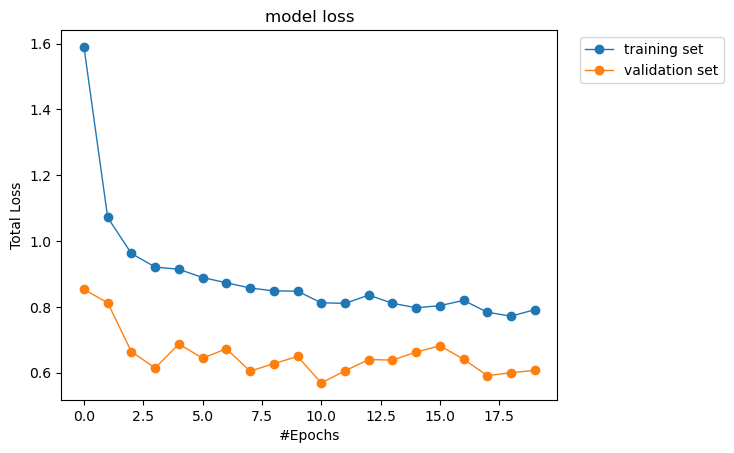

In [30]:
plt.plot(history.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(history.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("model loss")
plt.xlabel('#Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))

J'ai créée cette fonction generate_games pour synthétiser des jeux de données en utilisant mon modèle de prédiction d'actions ci-dessus. Elle permet de choisir aléatoirement des séquences de la base de données, de les ajuster à la longueur souhaitée pour un jeu, de prédire les actions correspondantes à l'aide du modèle, et de créer ainsi des jeux générés avec des séquences et leurs labels d'action associés.

In [38]:
import numpy as np

def generate_games(model, label_encoder, num_generated_games=15, game_length=10, game_type='normal'):
    generated_games = []

    for _ in range(num_generated_games):
        random_index = np.random.randint(0, len(df))
        generated_sequence = df.iloc[random_index]['norm']
        
        while len(generated_sequence) < game_length:
            generated_sequence += generated_sequence

        start_index = np.random.randint(0, len(generated_sequence) - game_length + 1)
        selected_sequence = generated_sequence[start_index:start_index + game_length]
        
        generated_sequence = np.array(selected_sequence).reshape(1, -1, 1)

        generated_prediction = model.predict(generated_sequence)

        generated_game = {'norm': selected_sequence,
                          'label': label_encoder.classes_[np.argmax(generated_prediction)]}

        generated_games.append(generated_game)

    return generated_games


num_generated_games = 10
game_length = 61
game_type = 'normal'

generated_games = generate_games(model, label_encoder, num_generated_games, game_length, game_type)

for i, game in enumerate(generated_games):
    print(f"Jeu généré {i + 1}: {game}")


1/1 [==============================] - 0s 59ms/step
Jeu généré 1: {'norm': [33.68659604830207, 47.402485690407424, 47.25914776855792, 43.21704274213183, 46.06288292290418, 58.48475486604103, 47.22877348867869, 32.31012059808994, 25.853961639226192, 23.50374215753247, 22.68315987113095, 22.455260838594693, 17.45270591000122, 13.745949702734457, 15.351901950521862, 14.954150232584501, 31.96043751953157, 21.079830389408215, 16.133955649993407, 15.836834696379166, 15.517858781505813, 16.748982132351724, 17.73019645857534, 18.352626722276185, 14.974300732347256, 16.61722390212986, 20.070230074410652, 20.604617429121667, 19.639909148198175, 24.595637856514312, 32.59157700638836, 31.529670941288032, 30.23830467582624, 28.941207500840576, 25.622237749799933, 23.044357590727152, 25.460998403325384, 20.609164224586834, 27.960796634746654, 38.21878885635444, 38.81645974540939, 37.30784294171166, 53.86221622094905, 29.029498693679365, 20.416728017030824, 20.754904594435725, 18.840215593234454, 20.

La deuxième approche se base sur les normes pour prédire l'action. Donc la norme n'est pas générée par le modèle. Dans ce qui suit, j'ai tenté à essayé une approche qui consiste à construire un modèle hybride qui prend en compte à la fois les données d'accélération (normes) et les actions associées. L'objectif est de prédire à la fois l'action du joueur et les normes d'accélération correspondantes.

Les séquences d'accélération sont traitées en utilisant la fonction pad_sequences pour les remplir avec des zéros et les ajuster à la même longueur. Cela garantit que toutes les séquences ont la même longueur, ce qui est essentiel pour l'entrée du modèle. D'autre part, les étiquettes d'actions encodées sont converties en représentation one-hot à l'aide de to_categorical. Cette représentation permet au modèle de comprendre les relations entre les différentes actions.

J'ai choisi une architecture de modèle avec deux couches distinctes pour traiter les données d'accélération et d'actions: une couche de masquage (Masking) comme avant, suivie d'une couche RNN (SimpleRNN) pour capturer les motifs séquentiels. La couche GlobalAveragePooling1D pour traiter les séquences de longueur variable en calculant la moyenne sur toute la séquence. Cela permet de générer une représentation fixe pour chaque séquence pour éviter tout erreur de code.

In [16]:
label_encoder = LabelEncoder()

df['encoded_label'] = label_encoder.fit_transform(df['label'])
num_classes = len(label_encoder.classes_)


X_norms = pad_sequences(df['norm'], padding='post', dtype='float32', truncating='post')
y_norms = pad_sequences(df['norm'], padding='post', dtype='float32', truncating='post')


X_actions = to_categorical(label_encoder.transform(df['label']), num_classes=num_classes)
y_actions = to_categorical(label_encoder.transform(df['label']), num_classes=num_classes)


X_norm_train, X_norm_test, X_actions_train, X_actions_test, y_actions_train, y_actions_test, y_norms_train, y_norms_test = train_test_split(
    X_norms, X_actions, y_actions, y_norms, test_size=0.2, random_state=42
)

input_layer_norm = Input(name='norm_input', shape=(X_norms.shape[1], 1))
input_layer_actions = Input(name='action_input', shape=(X_actions.shape[1], 1))

masking_layer_norm = Masking(mask_value=0.0)(input_layer_norm)
masking_layer_actions = Masking(mask_value=0.0)(input_layer_actions)

rnn_layer_norm = SimpleRNN(128, activation='relu', return_sequences=True)(masking_layer_norm)
rnn_layer_actions = SimpleRNN(128, activation='relu', return_sequences=True)(masking_layer_actions)

pooled_layer_norm = GlobalAveragePooling1D()(rnn_layer_norm)
pooled_layer_actions = GlobalAveragePooling1D()(rnn_layer_actions)

dense_layer_1 = Dense(64, activation='relu')(pooled_layer_actions)
dropout_layer_1 = Dropout(0.3)(dense_layer_1)
dense_layer_2 = Dense(32, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.2)(dense_layer_2)
dense_layer_3 = Dense(16, activation='relu')(dropout_layer_2)
dropout_layer_3 = Dropout(0.1)(dense_layer_3)

dense_norm_layer_1 = Dense(64, activation='relu')(pooled_layer_norm)
dropout_norm_layer_1 = Dropout(0.3)(dense_norm_layer_1)
dense_norm_layer_2 = Dense(32, activation='relu')(dropout_norm_layer_1)
dropout_norm_layer_2 = Dropout(0.2)(dense_norm_layer_2)
dense_norm_layer_3 = Dense(16, activation='relu')(dropout_norm_layer_2)
dropout_norm_layer_3 = Dropout(0.1)(dense_norm_layer_3)


action_output = Dense(num_classes, activation='softmax', name='action_output')(dropout_layer_3)

norm_output = Dense(X_norms.shape[1], activation='linear', name='norm_output')(dropout_norm_layer_3)

model = Model(inputs={'norm_input': input_layer_norm, 'action_input': input_layer_actions},
              outputs=[action_output, norm_output])

model.compile(loss={'action_output': 'categorical_crossentropy', 'norm_output': 'mean_squared_error'},
              optimizer='adam',
              metrics={'action_output': 'accuracy', 'norm_output': 'mae'})

history = model.fit({'norm_input': X_norm_train, 'action_input': X_actions_train},
                    {'action_output': y_actions_train, 'norm_output': y_norms_train},
                    epochs=60, batch_size=50, validation_split=0.1)

Epoch 1/60
18/18 [==============================] - 10s 385ms/step - loss: 225.4938 - action_output_loss: 2.1686 - norm_output_loss: 223.3252 - action_output_accuracy: 0.3103 - norm_output_mae: 3.6321 - val_loss: 193.3910 - val_action_output_loss: 2.1140 - val_norm_output_loss: 191.2770 - val_action_output_accuracy: 0.3895 - val_norm_output_mae: 3.7461
Epoch 2/60
18/18 [==============================] - 6s 346ms/step - loss: 191.3439 - action_output_loss: 2.0194 - norm_output_loss: 189.3246 - action_output_accuracy: 0.4649 - norm_output_mae: 4.8971 - val_loss: 135.6520 - val_action_output_loss: 1.8984 - val_norm_output_loss: 133.7537 - val_action_output_accuracy: 0.3895 - val_norm_output_mae: 2.7372
Epoch 3/60
18/18 [==============================] - 6s 345ms/step - loss: 149.8912 - action_output_loss: 1.7236 - norm_output_loss: 148.1677 - action_output_accuracy: 0.4578 - norm_output_mae: 4.2447 - val_loss: 108.7800 - val_action_output_loss: 1.5662 - val_norm_output_loss: 107.2139 - va

## **Dernière approche**

La dernière approche consiste à extraire toutes les caractéristiques statistiques possibles de la variable norme, et la remplace par ces informations. Ensuite, on peut prédire l'action et le mouvement du joueur, et on peut recrééer le jeu en utilisant la fonction generate_games définie ci-dessus. Cependant, cette approche ne permet pas de prédir l'action et la norme en meme temps, pour cela j'ai juste développée l'idée de cette approche, vue que le but est de recrééer le jeu et de générer à la fois l'action avec sa norme correspondante. 

In [50]:
df['norm_mean'] = df['norm'].apply(lambda x: pd.Series(x).mean())

df['norm_std'] = df['norm'].apply(lambda x: pd.Series(x).std())

df['norm_median'] = df['norm'].apply(lambda x: pd.Series(x).median())

df['norm_min'] = df['norm'].apply(lambda x: pd.Series(x).min())

df['norm_max'] = df['norm'].apply(lambda x: pd.Series(x).max())

df['norm_var'] = df['norm'].apply(lambda x: pd.Series(x).var())

df['norm_q1'] = df['norm'].apply(lambda x: pd.Series(x).quantile(0.25))

df['norm_q2'] = df['norm'].apply(lambda x: pd.Series(x).quantile(0.5))

df['norm_q3'] = df['norm'].apply(lambda x: pd.Series(x).quantile(0.75))

df['norm_iqr'] = df['norm'].apply(lambda x: pd.Series(x).quantile(0.75) - pd.Series(x).quantile(0.25))

df['norm_range'] = df['norm'].apply(lambda x: pd.Series(x).max() - pd.Series(x).min())

df

label                                               norm  norm_mean  \
0     walk  [23.177037336396975, 23.361525285249378, 21.53...  24.166958   
1     walk  [20.998214383911275, 19.182798059840767, 18.27...  26.026276   
2     walk  [21.95259682019565, 20.62720484424047, 22.5554...  23.998177   
3     walk  [19.39209748358647, 19.30460665293087, 18.9787...  22.596573   
4     rest  [22.069263037713093, 19.672270483203395, 19.88...  20.378778   
...    ...                                                ...        ...   
1182  walk  [23.337305769963503, 20.210987911153104, 25.06...  29.107628   
1183  walk  [22.470322813933603, 22.552427730975246, 23.84...  26.673605   
1184  walk  [43.833612705797144, 46.18045998580312, 37.492...  28.842287   
1185  walk  [30.927599255773355, 31.26358258808756, 28.286...  25.121496   
1186  walk  [30.94168559492879, 47.060036178960765, 37.195...  26.918923   

      longueur_norm   norm_std  norm_median   norm_min   norm_max    norm_var  \
0                72   6.007279    22.417711  15.392703  42.738486   36.087406   
1                54   8.558752    22.864346  15.520896  53.767061   73.252237   
2                68   6.375878    21.584619  14.484489  42.105998   40.651826   
3                75   5.582539    20.998214  14.867721  47.934160   31.164737   
4               181   0.741557    20.509409  17.789805  22.069263    0.549907   
...             ...        ...          ...        ...        ...         ...   
1182             52  11.026682    24.723429  11.190245  65.462316  121.587708   
1183             64   8.797734    23.684421  11.657530  51.724442   77.400115   
1184             60  12.274640    23.424746  15.539368  89.365797  150.666790   
1185             66  10.019122    23.016231   7.309930  71.505826  100.382813   
1186             72  11.113483    22.912946  12.060205  68.322510  123.509514   

        norm_q1    norm_q2    norm_q3   norm_iqr  norm_range  
0     20.468236  22.417711  26.232355   5.764119   27.345783  
1     19.889186  22.864346  30.006075  10.116888   38.246165  
2     19.961219  21.584619  26.674643   6.713424   27.621509  
3     19.483615  20.998214  24.141831   4.658217   33.066439  
4     19.882150  20.509409  20.864791   0.982641    4.279458  
...         ...        ...        ...        ...         ...  
1182  21.622941  24.723429  34.465576  12.842634   54.272071  
1183  21.204570  23.684421  29.316573   8.112003   40.066911  
1184  21.439840  23.424746  35.119446  13.679606   73.826429  
1185  19.385150  23.016231  29.990020  10.604870   64.195896  
1186  20.930884  22.912946  26.641234   5.710350   56.262304  

[1187 rows x 14 columns]

In [51]:
X = df.drop(["norm", "label"], axis=1)
Y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [52]:
xgboost_model = xgb.XGBClassifier(learning_rate=0.1,
                                  gamma=0.1,
                                  max_depth=5,
                                  min_child_weight=2,
                                  subsample=0.7,
                                  reg_lambda=1,
                                  alpha=0.1,
                                  n_estimators=50)


**Optimisation des hyperparamètres**:

In [51]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

param_grid = {
    'eta': [0.001, 0.01, 0.1],
    'gamma': [0, 1, 2, 5, 10, 20],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'reg_lambda': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 0.2],
    'n_estimators': [30, 50, 80]
}

random_search = RandomizedSearchCV(estimator=xgboost_model, param_distributions=param_grid, scoring='accuracy', cv=10)

# Exécuter la recherche par grille sur les données
random_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres:", random_search.best_params_)


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Meilleurs hyperparamètres: {'subsample': 1.0, 'reg_lambda': 0.2, 'n_estimators': 30, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 2, 'eta': 0.1, 'alpha': 0.1}


In [52]:
# Utiliser le modèle avec les meilleurs hyperparamètres pour faire des prédictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [53]:
# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Précision du modèle optimisé:", accuracy)


Précision du modèle optimisé: 0.7394957983193278


In [54]:
conf_matrix = confusion_matrix(y_test , y_pred)
conf_matrix

array([[ 1,  0,  0, 14,  0,  1,  1],
       [ 0,  0,  0,  7,  1,  0,  0],
       [ 0,  0,  5,  0,  0,  0,  3],
       [ 0,  0,  1, 95,  2,  0,  9],
       [ 0,  0,  0,  3,  0,  0,  0],
       [ 0,  0,  0,  6,  0,  0,  0],
       [ 0,  0,  2, 11,  0,  1, 75]])

In [ ]:
recreated_game_xgboost = [{'norm': X_test.iloc[i, :].tolist(), 'label': label} for i, label in enumerate(y_pred)]